In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)

In [2]:
import numpy as np
import pickle
import os
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

# Adjust these imports to match your project structure
from utils.embedding_extraction import extract_embedding
from config.constants import MODELS_DIR, PROCESSED_AUDIO_DATA_DIR, CLEANED_AUDIO_DATA_DIR

# --- 1. NEW CONSTANT FOR SCALER ---
MODEL_PATH = MODELS_DIR / 'instrument_classifier.h5'
LE_PATH = MODELS_DIR / 'label_encoder.pkl'
SCALER_PATH = MODELS_DIR / 'scaler.pkl'  # <--- CHANGE 1: Define Scaler Path

print("Loading resources...")

# Load Model
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model not found at {MODEL_PATH}")
custom_model = load_model(MODEL_PATH)
print("✅ Custom Model loaded.")

# Load Label Encoder
if not os.path.exists(LE_PATH):
    raise FileNotFoundError(f"Label Encoder not found at {LE_PATH}")
with open(LE_PATH, 'rb') as f:
    label_encoder = pickle.load(f)
print("✅ Label Encoder loaded.")

# --- 2. LOAD THE SCALER ---
if not os.path.exists(SCALER_PATH):
    raise FileNotFoundError(f"Scaler not found at {SCALER_PATH}. Did you save it during training?")
with open(SCALER_PATH, 'rb') as f:
    scaler = pickle.load(f)
print("✅ Scaler loaded.")  # <--- CHANGE 2: Load the Scaler

C:\Users\Hakim\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


Loading resources...
✅ Custom Model loaded.
✅ Label Encoder loaded.
✅ Scaler loaded.


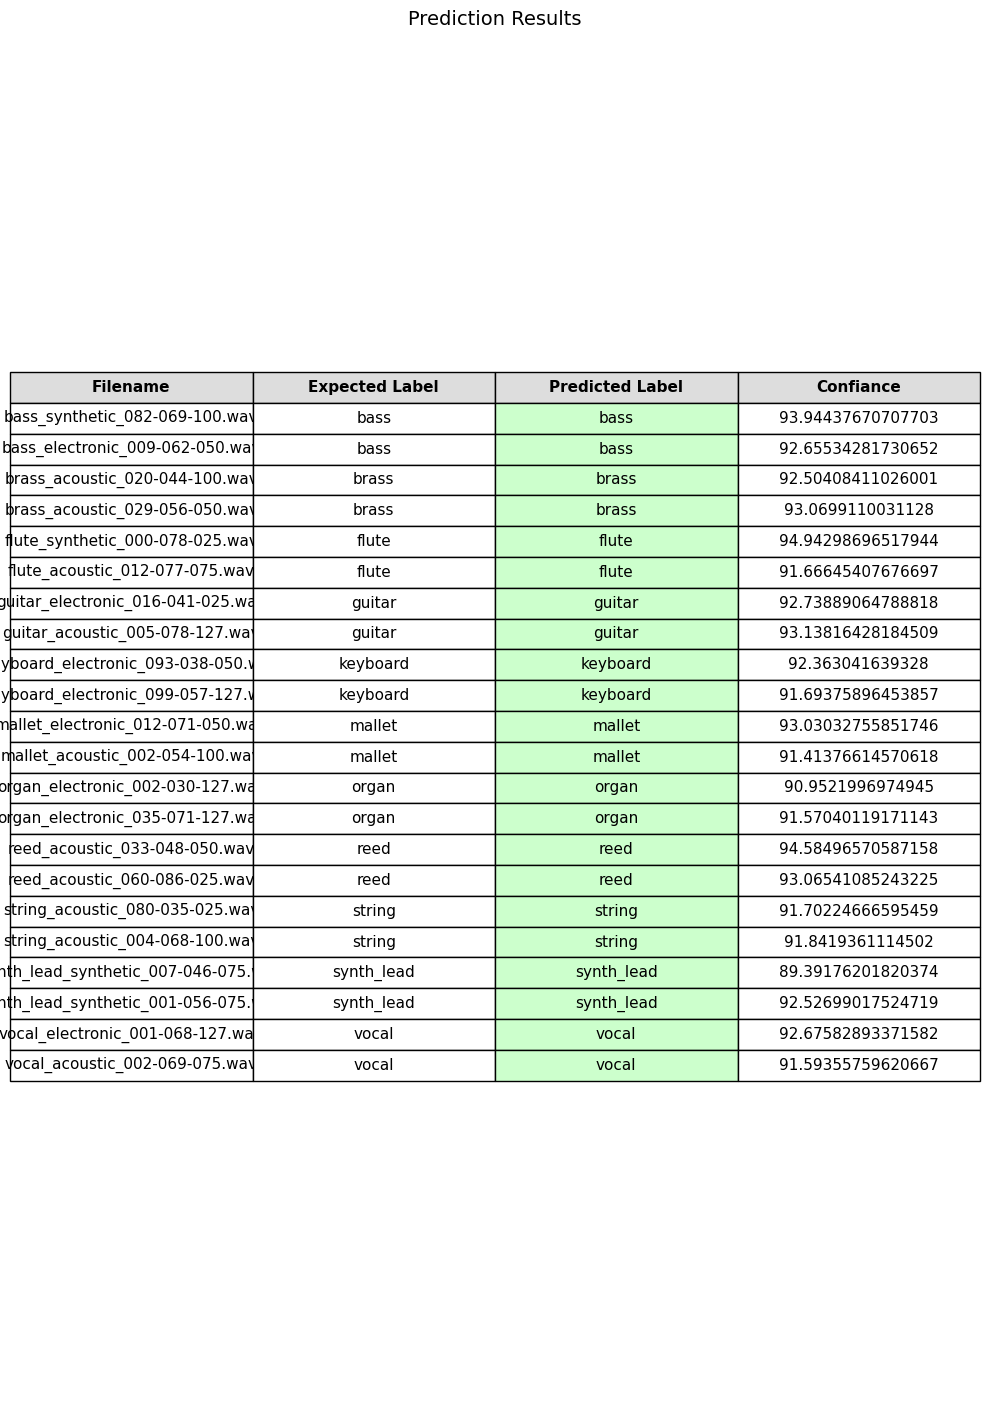

In [4]:
def predict_instrument(audio_path):
    """
    Predicts the instrument label for a given audio file.
    """
    # 1. Extract features using YAMNet
    embedding = extract_embedding(audio_path)

    if embedding is None:
        return "Error reading audio", 0.0

    # Reshape to (1, 1024)
    features = embedding.reshape(1, -1)

    # --- 3. APPLY SCALING ---
    # We use .transform(), NOT .fit_transform()
    features_scaled = scaler.transform(features)  # <--- CHANGE 3: Scale the features

    # 2. Predict using the SCALED features
    prediction_scores = custom_model.predict(features_scaled, verbose=0)

    # 3. Process results
    predicted_index = np.argmax(prediction_scores)
    confidence = prediction_scores[0][predicted_index]

    # 4. Convert index back to Label string
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]

    return predicted_label, confidence

TEST_DATA = PROCESSED_AUDIO_DATA_DIR / 'selected.csv'
df = pd.read_csv(TEST_DATA)

results = []

for _, row in df.iterrows():
    filename = row["filename"]
    expected_label = row["label"]
    predicted_label, confiance = predict_instrument(CLEANED_AUDIO_DATA_DIR / filename)

    results.append([
        filename,
        expected_label,
        predicted_label,
        confiance*100
    ])

results_df = pd.DataFrame(
    results,
    columns=["Filename", "Expected Label", "Predicted Label", "Confiance"]
)

# -----------------------------
# Matplotlib Table
# -----------------------------
fig, ax = plt.subplots(figsize=(10, len(results_df) * 0.6 + 1))
ax.axis("off")

table = ax.table(
    cellText=results_df.values,
    colLabels=results_df.columns,
    loc="center",
    cellLoc="center"
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.5)

# Highlight mismatches
for i in range(len(results_df)):
    # Row index + 1 because of header
    # Col index 2 is "Predicted Label"
    expected = results_df.iloc[i]["Expected Label"]
    predicted = results_df.iloc[i]["Predicted Label"]

    if expected != predicted:
        table[(i + 1, 2)].set_facecolor("#ffcccc")  # Red for error
    else:
        table[(i + 1, 2)].set_facecolor("#ccffcc")  # Green for success

# Header style
for j in range(len(results_df.columns)):
    table[(0, j)].set_facecolor("#dddddd")
    table[(0, j)].set_text_props(weight='bold')

plt.title("Prediction Results", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Manual Test

In [9]:
# flute
test_file = "C:\\Users\Hakim\Documents\ENSET\IA_Avance\music-instrument-classfication\data\\raw\\nsynth\\test\\audio\\flute_acoustic_002-098-025.wav"

# Bass
# test_file = "C:\\Users\Hakim\Documents\ENSET\IA_Avance\music-instrument-classfication\data\\raw\\nsynth\\test\\audio\\bass_synthetic_134-045-100.wav"

# Brass
# test_file = "C:\\Users\Hakim\Downloads\TRMPTSCH.WAV"

# Guitar
# test_file = "C:\\Users\Hakim\Documents\ENSET\IA_Avance\music-instrument-classfication\data\\raw\\nsynth\\test\\audio\\guitar_acoustic_010-106-050.wav"
# test_file = "C:\\Users\Hakim\Downloads\\60s_Rock_Guitar - Cleangtr D3.wav"

# String
# test_file = "C:\\Users\Hakim\Documents\ENSET\IA_Avance\music-instrument-classfication\data\\raw\\nsynth\\test\\audio\\string_acoustic_014-046-100.wav"

# Violin
#test_file = "C:\\Users\Hakim\Downloads\G4_fla.wav"

# Saxophone
# test_file = "C:\\Users\Hakim\Downloads\TENORSA.WAV"
# test_file = "C:\\Users\Hakim\Downloads\sax.wav"

# Keyboard
# test_file = "C:\\Users\Hakim\Downloads\c4_plant1.wav"

# Pinao
# test_file = "C:\\Users\Hakim\Downloads\e1.wav"

# Clarinet
# test_file = "C:\\Users\Hakim\Downloads\\natural2.wav"

# Mallet
# test_file = "C:\\Users\Hakim\Downloads\MARIMBA.WAV"

print(f"\nTesting on: {test_file}")
if os.path.exists(test_file):
    label, conf = predict_instrument(test_file)
    print(f"🎸 Prediction: {label}")
    print(f"📊 Confidence: {conf*100:.2f}%")
else:
    print("⚠️ File not found. Please update 'test_file' variable with a valid path.")


Testing on: C:\Users\Hakim\Documents\ENSET\IA_Avance\music-instrument-classfication\data\raw\nsynth\test\audio\flute_acoustic_002-098-025.wav
🎸 Prediction: flute
📊 Confidence: 93.82%
